### Part 2: Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;) 

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.
! pip install subword-nmt
! pip install nltk
! pip uninstall -y torchtext
! pip install torchtext==0.6.0
! pip install transformers
# ! pip install deeppavlov

Uninstalling torchtext-0.9.1:
  Successfully uninstalled torchtext-0.9.1
     |████████████████████████████████| 71kB 3.9MB/s 
     |████████████████████████████████| 1.2MB 7.9MB/s 
     |████████████████████████████████| 2.0MB 6.1MB/s 
     |████████████████████████████████| 3.2MB 43.3MB/s 
     |████████████████████████████████| 890kB 41.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=70a6ce96daf91fc2a0fef1f755576b08d8d7ab222b599e061b42b84f7c3414f6
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github. Loading special files as well")
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_s21/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github. Loading special files as well
--2021-03-31 06:14:34--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_s21/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  35.6MB/s    in 0.3s    

2021-03-31 06:14:35 (35.6 MB/s) - ‘data.txt’ saved [12905334/12905334]



In [3]:
if not os.path.exists('./utils.py'):
    print("utils file not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_s21/homeworks_advanced/Lab1_NLP/utils.py -nc

if not os.path.exists('./my_network.py'):
    print("network file not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_s21/homeworks_advanced/Lab1_NLP/my_network.py -nc

utils file not found locally. Downloading from github.
--2021-03-31 06:14:37--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_s21/homeworks_advanced/Lab1_NLP/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 932 [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]     932  --.-KB/s    in 0s      

2021-03-31 06:14:37 (55.1 MB/s) - ‘utils.py’ saved [932/932]

network file not found locally. Downloading from github.
--2021-03-31 06:14:37--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_s21/homeworks_advanced/Lab1_NLP/my_network.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw

In [4]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import transformers as ppb

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE


### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [5]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [6]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = torchtext.data.TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [7]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [8]:
## load pretrained Russian model

In [9]:
# # For DistilBERT:
# model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# ## Want BERT instead of distilBERT? Uncomment the following line:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'DeepPavlov/rubert-base-cased')

# # Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert = model_class.from_pretrained(pretrained_weights)
# from deeppavlov import build_model, configs

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
device

device(type='cuda')

In [13]:
bert = bert.to(device)

In [46]:
def transform_batch_src(batch, model):
    orig_texts = [" ".join([SRC.vocab.itos[i] for i in batch[:, j] if i not in[0, 1, 2, 3]]) for j in range((batch.size(1)))]
    tokenized = list(map(lambda x: tokenizer.encode(x, add_special_tokens=True), orig_texts))
    max_len = 0
    for tok in tokenized:
        if len(tok) > max_len:
            max_len = len(tok)
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized])
    attention_mask = np.where(padded != 0, 1, 0)
    attention_mask.shape

    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    return last_hidden_states['last_hidden_state'].permute(1, 0, 2)

# def transform_batch_trg(batch, model):
   
#     orig_texts = [" ".join([TRG.vocab.itos[i] for i in batch[:, j] if i not in[0, 1, 2, 3]]) for j in range((batch.size(0)))]
#     tokenized = list(map(lambda x: tokenizer.encode(x, add_special_tokens=True), orig_texts))
#     max_len = 0
#     for tok in tokenized:
#         if len(tok) > max_len:
#             max_len = len(tok)
#     padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized])
#     attention_mask = np.where(padded != 0, 1, 0)
#     attention_mask.shape

#     input_ids = torch.tensor(padded)  
#     attention_mask = torch.tensor(attention_mask)
#     input_ids = input_ids.to(device)
#     attention_mask = attention_mask.to(device)
#     with torch.no_grad():
#         last_hidden_states = model(input_ids, attention_mask=attention_mask)
#     return last_hidden_states['last_hidden_state'].permute(1, 0, 2)

In [47]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [48]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [49]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9284
Unique tokens in target (en) vocabulary: 6698


Here are tokens from original (RU) corpus:

In [19]:
SRC.vocab.itos[::1000]

['<unk>',
 'hotel',
 'valley',
 'иль',
 'электрические',
 'cannes',
 'luka',
 'функцией',
 'джойоза',
 'стульчик']

And from target (EN) corpus:

In [20]:
TRG.vocab.itos[::1000]

['<unk>', 'first', 'early', 'chi', 'napoleon', 'sizes', 'mackerel']

And here is example from train dataset:

In [21]:
print(vars(train_data.examples[9]))

{'trg': ['vibo', 'valentia', 'is', 'a', '45', '-', 'minute', 'drive', 'from', 'the', 'property', '.'], 'src': ['город', 'вибо', '-', 'валентия', 'находится', 'в', '45', '-', 'минутах', 'езды', 'от', 'отеля', '.']}


Let's check the length distributions:

Length distribution in Train data


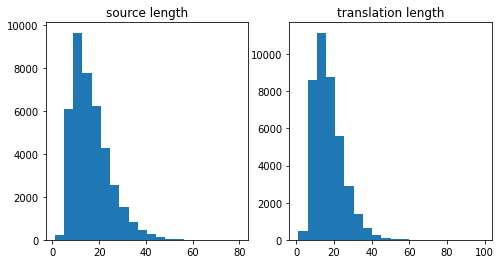

In [22]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


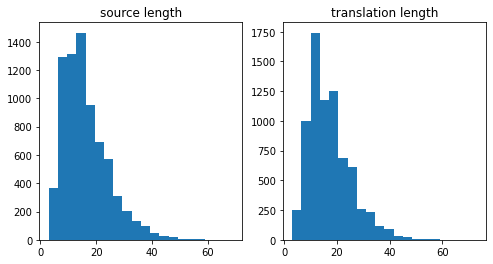

In [23]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [24]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [25]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 47x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 45x128 (GPU 0)]
torch.Size([45, 128]) torch.Size([47, 128])


In [ ]:
import my_network
Seq2Seq = my_network.Seq2Seq
AttentionDecoder = my_network.AttentionDecoder

In [26]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
#         self.dropout = dropout
        
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=emb_dim
        )

        self.emb_dim_reduce = nn.Linear(768, emb_dim)
            # <YOUR CODE HERE>
        
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout
        )
            # <YOUR CODE HERE>
        
        self.dropout = nn.Dropout(p=dropout)# <YOUR CODE HERE>
        
    def forward(self, src):
        
        #src = [src sent len, batch size]
        bert_emb = transform_batch_src(src, bert)
        embedded = self.emb_dim_reduce(bert_emb)
        
        output, (hidden, cell) = self.rnn(embedded)
        
        return output, hidden, cell

In [27]:
#CODE FOR DECODER WITH ATTENTION

INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = AttentionDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [28]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9284, 256)
    (emb_dim_reduce): Linear(in_features=768, out_features=256, bias=True)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): AttentionDecoder(
    (embedding): Embedding(6698, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6698, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (attention): Attention(
      (linear): Linear(in_features=512, out_features=512, bias=True)
    )
  )
)

In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 15,343,402 trainable parameters


In [30]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, INPUT_DIM)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [31]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        #scheduler.step()
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [32]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [33]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [58]:
train_history = []
valid_history = []

N_EPOCHS = 5 
#in general n_eposh was 20, because 10 epochs weren't enough, and I add 10 epochs
#N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

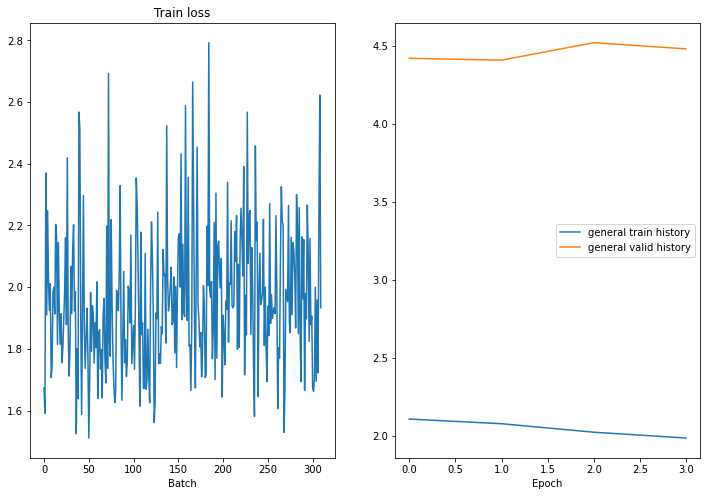

Epoch: 05 | Time: 5m 9s
	Train Loss: 1.961 | Train PPL:   7.107
	 Val. Loss: 4.441 |  Val. PPL:  84.842


In [59]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [60]:
del utils

In [61]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [62]:
batch = next(iter(test_iterator))

In [63]:
for idx in [1,2]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: massages can be arranged .
Generated: massage services are available .

Original: for your comfort , you will find bathrobes and slippers .
Generated: for your comfort , you will find bath robes and slippers .



In [64]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [65]:
import tqdm

In [66]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:27,  2.15it/s]


In [67]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

29.022864323202292

Baseline solution BLEU score is quite low. Try to achieve at least __24__ BLEU on the test set. 
The checkpoints are:

* __22__ - minimal score to submit the homework, 30% of points

* __27__ - good score, 70% of points

* __29__ - excellent score, 100% of points